# Auto encoder

## VAE


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 173.370460122
Epoch: 0006 cost= 109.510678586
Epoch: 0011 cost= 104.532972468
Epoch: 0016 cost= 102.341748505
Epoch: 0021 cost= 100.785458332
Epoch: 0026 cost= 99.406616766
Epoch: 0031 cost= 98.483148485
Epoch: 0036 cost= 97.761160251
Epoch: 0001 cost= 190.116370073
Epoch: 0006 cost= 153.590973372
Epoch: 0011 cost= 147.935793263
Epoch: 0016 cost= 145.327090759
Epoch: 0021 cost= 143.745557001
Epoch: 0026 cost= 142.628145225
Epoch: 0031 cost= 141.676406000
Epoch: 0036 cost= 141.069547979


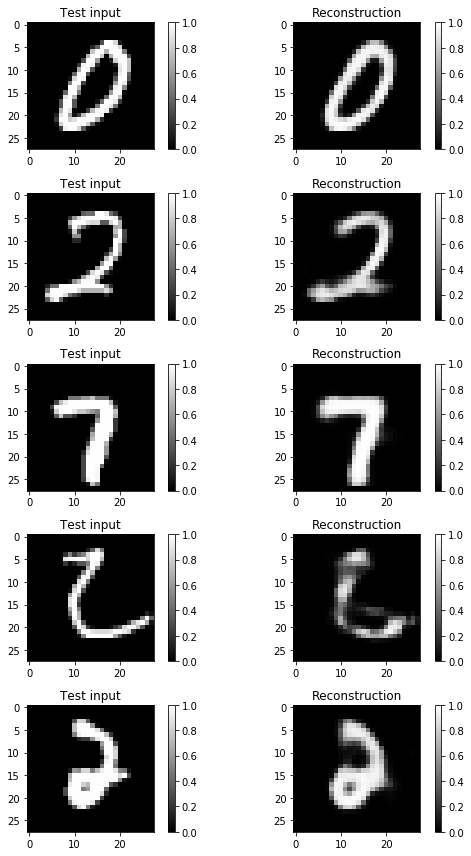

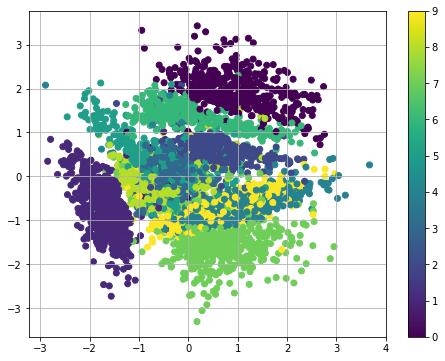

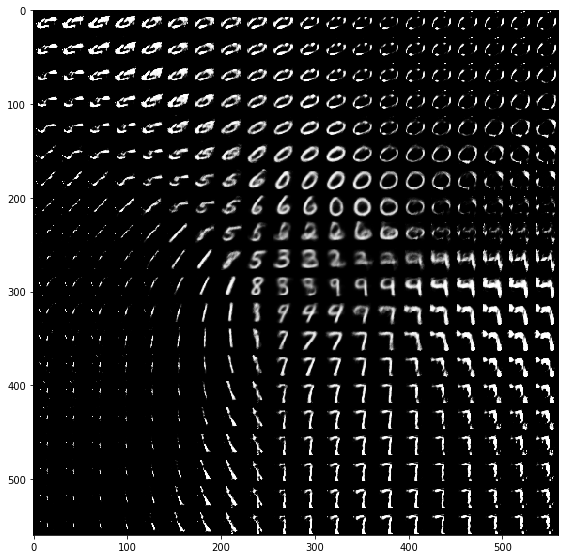

In [3]:
"""
https://jmetzen.github.io/2015-11-27/vae.html
예제4: VAE
참고문헌: Auto-Encoding Variational Bayes - Kingma and Welling (2013)
"""

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

# Load MNIST data in a format suited for tensorflow.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
n_samples = mnist.train.num_examples

def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of neural network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

class VAE(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent space
        self.z_mean, self.z_log_sigma_sq = \
            self._encoder_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._decoder_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _encoder_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _decoder_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})
        
#We can now define a simple fuction which trains the VAE using mini-batches:        
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VAE(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

#We can now train a VAE on MNIST by just specifying the network topology. 
#We start with training a VAE with a 20-dimensional latent space.
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=36)

#Based on this we can sample some test inputs and visualize 
#how well the VAE can reconstruct those. In general the VAE does really well.
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

#=========== Illustrating latent space ===============#
#Next, we train a VAE with 2d latent space and illustrates 
#how the encoder (the recognition network) encodes some of 
#the labeled inputs (collapsing the Gaussian distribution 
#in latent space to its mean). This gives us some insights into 
#the structure of the learned manifold (latent space)
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=36)

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

nx = ny = 20
x_values = np.linspace(-6, 6, nx)
y_values = np.linspace(-6, 6, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

#An other way of getting insights into the latent space is to use 
#the generator network to plot reconstrunctions at the positions 
#in the latent space for which they have been generated:
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()



# GAN

## Cycle GAN

W0729 07:34:11.258137 140336260757376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1 DiscriminatorA Loss= 0.249986,DiscriminatorB Loss= 0.246597, Generator Loss= 0.344509, Avg Loss=0.865273
Epoch: 2 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.241509, Generator Loss= 0.311218, Avg Loss=0.845010
Epoch: 3 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.482053, Generator Loss= 0.564237, Avg Loss=1.143124
Epoch: 4 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.515678, Generator Loss= 0.861320, Avg Loss=1.477398
Epoch: 5 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.499989, Generator Loss= 0.923950, Avg Loss=1.632165
Epoch: 6 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.499998, Generator Loss= 0.929282, Avg Loss=1.652325
Epoch: 7 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.500000, Generator Loss= 0.907526, Avg Loss=1.642199
Epoch: 8 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.500000, Generator Loss= 0.876604, Avg Loss=1.617554
Epoch: 9 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.500000, Generator Loss= 0.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


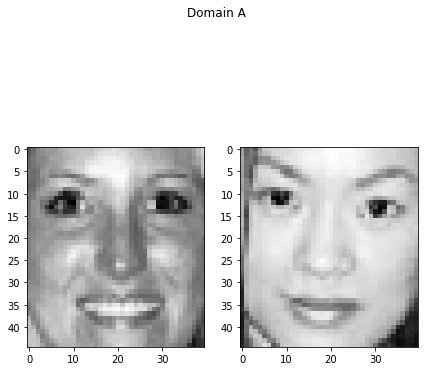

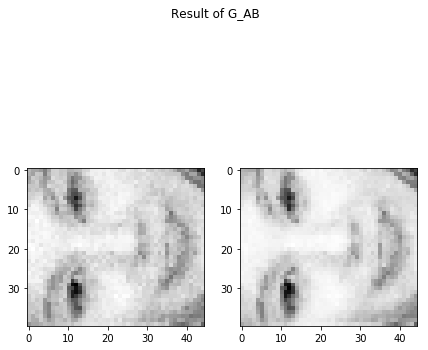

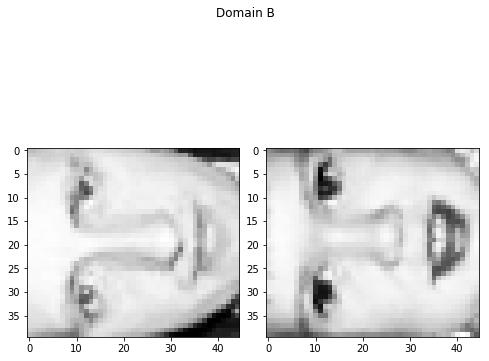

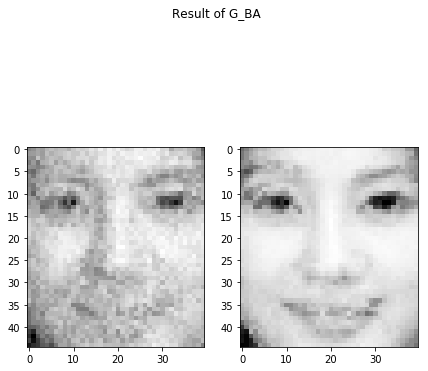

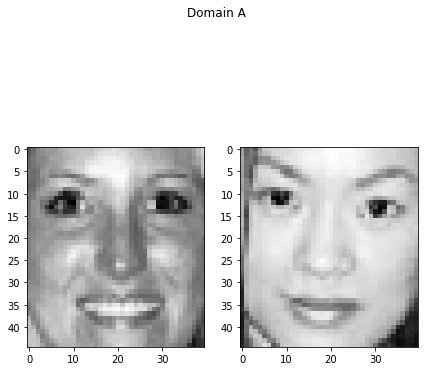

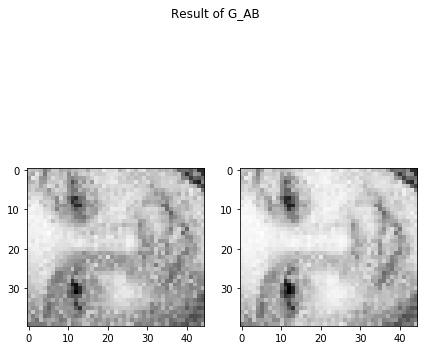

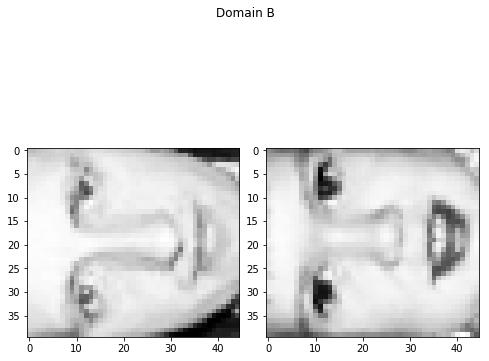

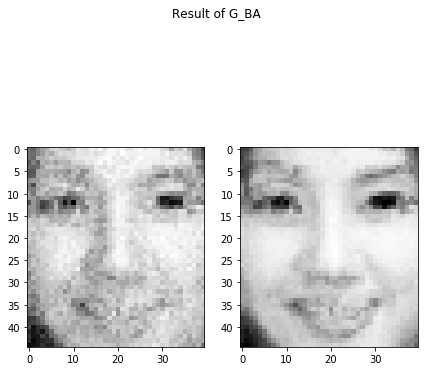

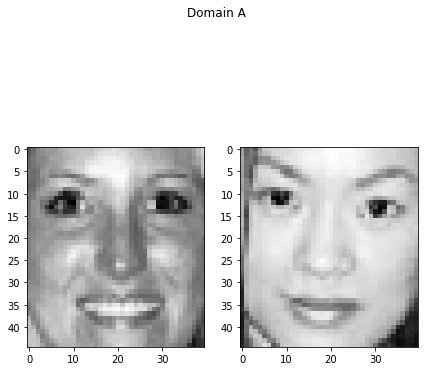

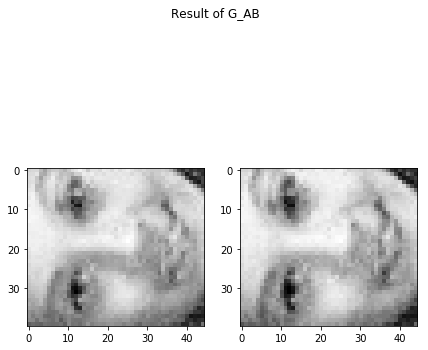

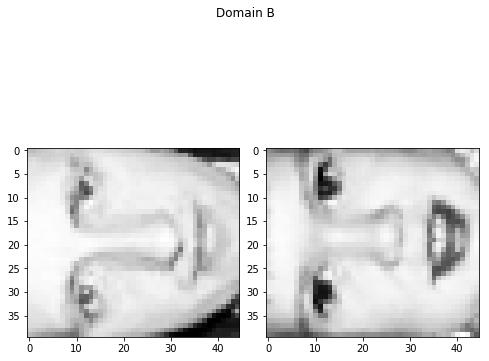

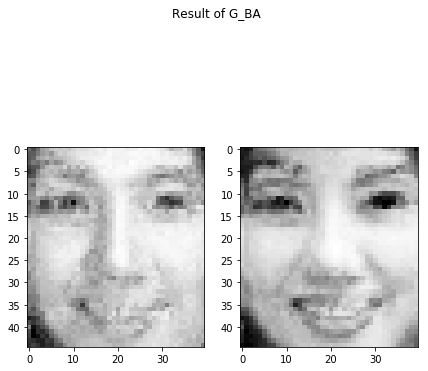

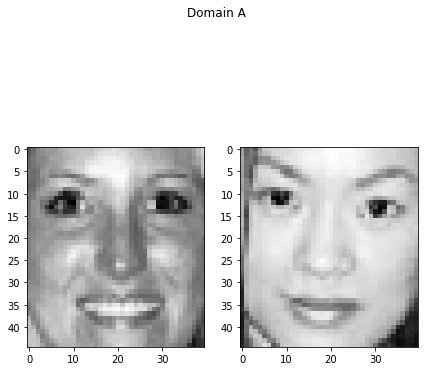

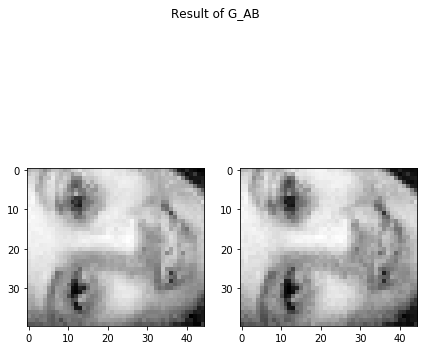

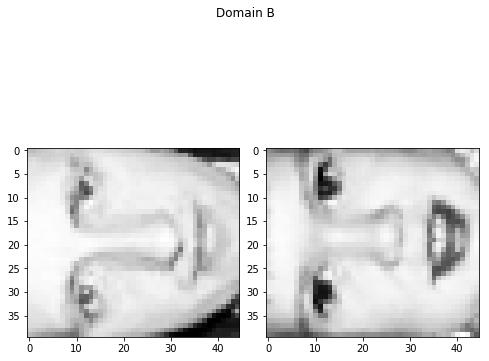

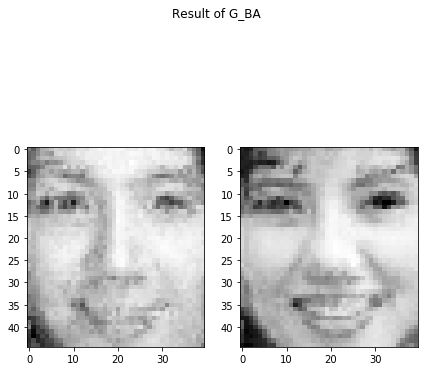

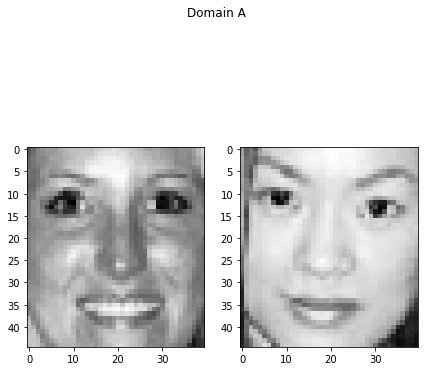

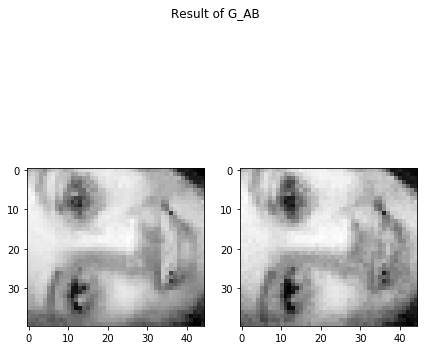

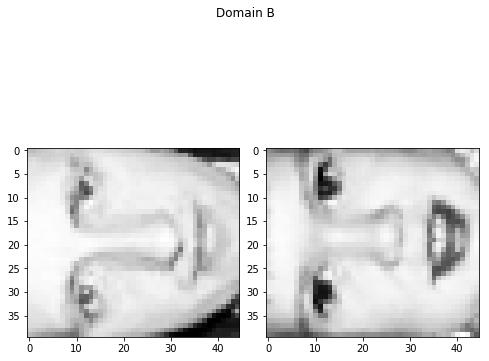

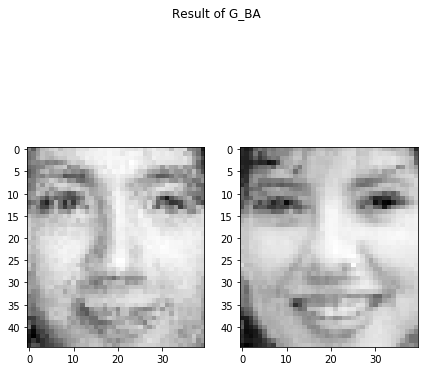

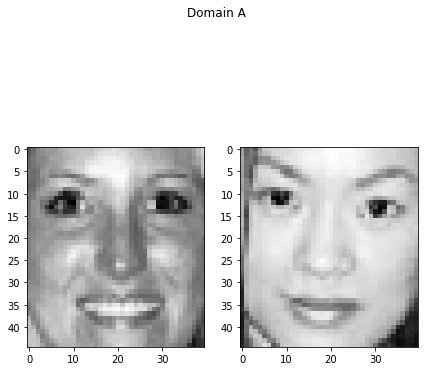

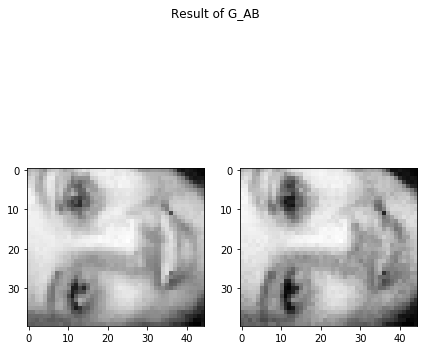

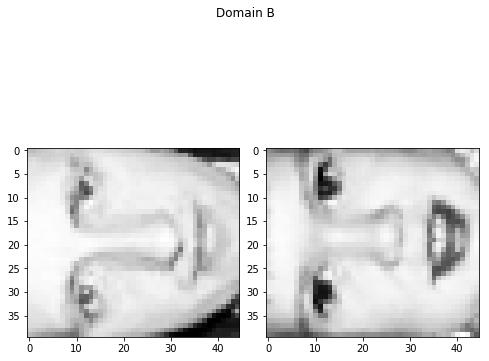

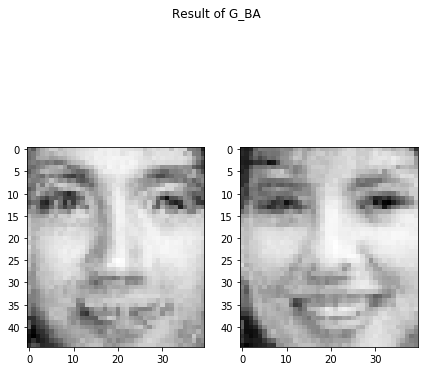

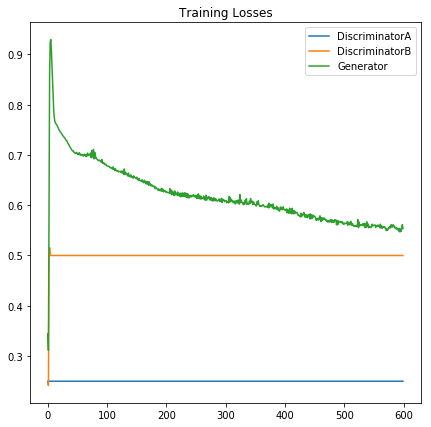

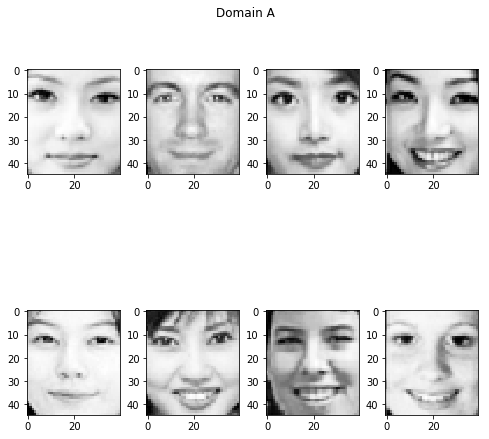

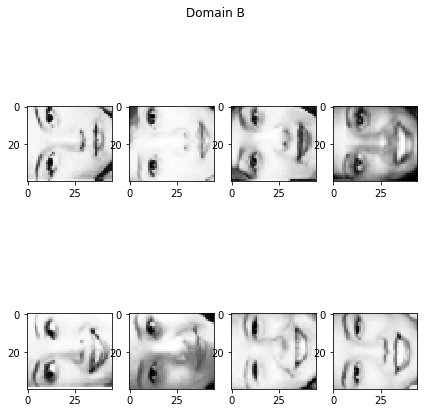

In [7]:
#============================================================#
# 예제 8: 인물 이미지 변형을 위한 CycleGAN 구현
#============================================================#

"""
이 예제에서 사용하는 이미지 데이터는 DCGAN에서 사용한 인물 흑백 이미지 20장이다. 
20장 중 10장은 정상 이미지 x(도메인 A), 10장은 회전한 이미지로 변형하여 y(도메인 B)로 사용한다. 
도메인 A에 속하는 이미지를 입력하면 회전한 이미지로 변형하고, 도메인 B에 속하는 
회전한 이미지를 입력하면 정상 이미지로 변형하는 CycleGAN을 만드는 것이 목적이다. 
단, 도메인 A에 속하는 이미지를 회전한 이미지가 도메인 B에 존재한다고
확신할 수 없다는 사실에 주의한다.

생성자(G=G_AB, F=G_BA)와 판별자(D_A, D_B)는 입력층, 1개의 은닉층 및 출력층으로
구성된 전방향 신경망이다. 인물 이미지는 45*40 = 1800 픽셀의 이미지이므로 생성자의 출
력층은 1,800개의 출력노드를 가진다. 모든 출력노드에 적용되는 활성함수로 시그모이드 함
수를 사용하고 모든 가중치는 Xavier 초기치를 사용한다.
"""

# 필요한 라이브러리 불러들임 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as Im
import os
import glob  


# 그래프 리셋
tf.reset_default_graph() 
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
 
#os.chdir('C:/Users/admin/Dropbox/저서/텐서플로_딥러닝/GANs_tensorflow/')
path = '/content/drive/My Drive/lecture/l_d/p6/AE_Gan'
files=glob.glob(path + '/face20/*.png')

img=[]          
for file in files:
    a=Im.open(file) 
    a=a.convert('L') # 흑백화면으로 
    a1=np.array(a)
    img.append(a1)        
    

xr=np.asarray(img)/255. # convert list to array

nr=np.prod(xr.shape[1:3]) # 45*40=1800
Xr=np.reshape(xr,[len(img),nr]) #=[20,1800]


import scipy.ndimage.interpolation
# Real image
X_rA = Xr[:10]
# Rotated image
X_rB = Xr[10:].reshape(-1, 45, 40)
X_rB = scipy.ndimage.interpolation.rotate(X_rB, 90, axes=(1, 2))
X_rB = X_rB.reshape(-1, 45*40)

# divide to train and test
XA=X_rA[0:2,:]
X_trainA=X_rA[2:10,:]
XB=X_rB[0:2,:]
X_trainB=X_rB[2:10,:]

# 훈련용과 시험용 이미지 개수와 입력 변수의 수
sample_size= X_trainA.shape[0] #8 
sample_size_test= XA.shape[0] #2 
X_dim = X_trainA.shape[1] #=1800
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 300
# 학습률 : 0.001

learning_rate = 0.001
batch_size = 2
epochs =600 # no. of epochs
h_dim = 128

# 입력 이미지 placeholder
X_A = tf.placeholder(tf.float32, shape=[None, X_dim])
X_B = tf.placeholder(tf.float32, shape=[None, X_dim])


# 판별자의 가중치와 편의(# 사비에르 초기치 사용)
D_A_W1 = tf.get_variable('D_A_W1',shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
D_A_b1 = tf.Variable(tf.zeros([h_dim]))
D_A_W2 = tf.get_variable('D_A_W2', shape=[h_dim, 1],initializer=tf.contrib.layers.xavier_initializer())
D_A_b2 = tf.Variable(tf.zeros([1]))

D_B_W1 = tf.get_variable('D_B_W1', shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
D_B_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_B_W2 = tf.get_variable('D_B_W2', shape=[h_dim, 1],initializer=tf.contrib.layers.xavier_initializer())
D_B_b2 = tf.Variable(tf.zeros([1]))

# 생성자의 가중치와 편의(# 사비에르 초기치 사용)
G_AB_W1 = tf.get_variable('D_AB_W1', shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
G_AB_b1 = tf.Variable(tf.zeros([h_dim]))
G_AB_W2 = tf.get_variable('D_AB_W2', shape=[h_dim, X_dim],initializer=tf.contrib.layers.xavier_initializer())
G_AB_b2 = tf.Variable(tf.zeros([X_dim]))

G_BA_W1 = tf.get_variable('D_BA_W1', shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
G_BA_b1 = tf.Variable(tf.zeros([h_dim]))
G_BA_W2 = tf.get_variable('D_BA_W2', shape=[h_dim, X_dim],initializer=tf.contrib.layers.xavier_initializer())
G_BA_b2 = tf.Variable(tf.zeros([X_dim]))


# 모수 모음
theta_DA = [D_A_W1, D_A_W2, D_A_b1, D_A_b2]
theta_DB= [ D_B_W1, D_B_W2, D_B_b1, D_B_b2]
theta_G = [G_AB_W1, G_AB_W2, G_AB_b1, G_AB_b2,
           G_BA_W1, G_BA_W2, G_BA_b1, G_BA_b2]

#------------------------------------------------
# 생성자 정의:
#------------------------------------------------
def G_AB(X):
    h1 = tf.nn.relu(tf.matmul(X, G_AB_W1) + G_AB_b1)
    return tf.nn.sigmoid(tf.matmul(h1, G_AB_W2) + G_AB_b2)


def G_BA(X):
    h1 = tf.nn.relu(tf.matmul(X, G_BA_W1) + G_BA_b1)
    return tf.nn.sigmoid(tf.matmul(h1, G_BA_W2) + G_BA_b2)

#------------------------------------------------
# 판별자 정의:
#------------------------------------------------
def D_A(X):
    h1 = tf.nn.relu(tf.matmul(X, D_A_W1) + D_A_b1)
    return tf.nn.sigmoid(tf.matmul(h1, D_A_W2) + D_A_b2)


def D_B(X):
    h1 = tf.nn.relu(tf.matmul(X, D_B_W1) + D_B_b1)
    return tf.nn.sigmoid(tf.matmul(h1, D_B_W2) + D_B_b2)



# 생성(변형)결과 
X_AB = G_AB(X_A)
X_BA = G_BA(X_B)


# 판별자 D_A 결과 
D_A_real = D_A(X_A)
D_A_fake = D_A(X_BA)

# 판별자 D_B 결과
D_B_real = D_B(X_B)
D_B_fake = D_B(X_AB)

# 복원( x -> G(x)-> F(G(x)-> x))
X_ABA = G_BA(X_AB)

# 복원( y -> F(x)-> G(F(x)-> y))
X_BAB = G_AB(X_BA)


# 판별자 비용함수 (LSGAN 적용)
DA_loss = 0.5 * (tf.reduce_mean((D_A_real - 1)**2)+ 0.5*tf.reduce_mean(D_A_fake**2))
DB_loss = 0.5 * (tf.reduce_mean((D_B_real - 1)**2)+ 0.5*tf.reduce_mean(D_B_fake**2))

# 생성자 비용함수
GAB_loss = 0.5 * tf.reduce_mean((D_A_fake - 1)**2)+0.5 * tf.reduce_mean((D_B_fake - 1)**2)

# 복원에 대한 비용함수
C_loss=tf.reduce_mean(tf.abs(X_A-X_ABA))+tf.reduce_mean(tf.abs(X_B-X_BAB))
G_loss=GAB_loss+C_loss


# Optimizer
DA_solver = tf.train.AdamOptimizer(learning_rate).minimize(DA_loss, var_list=theta_DA)
DB_solver = tf.train.AdamOptimizer(learning_rate).minimize(DB_loss, var_list=theta_DB)
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)


#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())
losses = []
for epoch in range(epochs):
    total_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(total_batch):
        if ii!=total_batch:
              XrA=X_trainA[ii*batch_size:(ii+1)*batch_size]
              XrB=X_trainB[ii*batch_size:(ii+1)*batch_size]
        else:
              XrA=X_trainA[(ii+1)*batch_size:]           
              XrB=X_trainB[(ii+1)*batch_size:]         
        DA_loss_curr,_ = sess.run([DA_loss,DA_solver], feed_dict={X_A: XrA, X_B: XrB})
        DB_loss_curr,_ = sess.run([DB_loss,DB_solver], feed_dict={X_A: XrA, X_B: XrB})
        G_loss_curr,_ = sess.run([G_loss,G_solver], feed_dict={X_A: XrA, X_B: XrB})    
        losss=DA_loss_curr+DB_loss_curr+G_loss_curr
        avg_loss+=losss/total_batch
    print('Epoch: %d' %(epoch+1),'DiscriminatorA Loss= %f,DiscriminatorB Loss= %f, Generator Loss= %f, Avg Loss=%f' %(DA_loss_curr, DB_loss_curr,G_loss_curr, avg_loss))   
    losses.append((DA_loss_curr, DB_loss_curr,G_loss_curr,avg_loss))
    # 100 에폭마다 변형되는 이미지 그림
    if (epoch+1)%100==0:  
        samples_A = sess.run(X_BA, feed_dict={X_B: XB})
        samples_B = sess.run(X_AB, feed_dict={X_A: XA})
        # 도메인  A의 test 이미지
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        for ii in range(2):
            plt.subplot(1,2,ii+1); plt.suptitle('Domain A') 
            plt.imshow(XA[ii].reshape(45,40),'Greys_r')
        # G_AB(X_A) 결과               
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)      
        for ii in range(2):
            plt.subplot(1,2,ii+1); plt.suptitle('Result of G_AB') 
            plt.imshow(samples_B[ii].reshape(40,45),'Greys_r')
        # 도메인  B의 test 이미지
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        f.tight_layout()
        for ii in range(2):
            plt.subplot(1,2,ii+1);plt.suptitle('Domain B') 
            plt.imshow(XB[ii].reshape(40,45),'Greys_r')
        # G_BA(X_B) 결과          
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)     
        for ii in range(2):
            plt.subplot(1,2,ii+1);plt.suptitle('Result of G_BA') 
            plt.imshow(samples_A[ii].reshape(45,40),'Greys_r')  
                
        
# 판별자, 생성자의 비용함수 그림 
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='DiscriminatorA')
plt.plot(losses.T[1], label='DiscriminatorB')
plt.plot(losses.T[2], label='Generator')
plt.title("Training Losses")
plt.legend()


# 도메인 A 에 속하는 이미지
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
f.tight_layout()
for ii in range(8):
    plt.subplot(2,4,ii+1); f.suptitle('Domain A')
    plt.imshow(X_trainA[ii].reshape(45,40),'Greys_r')

# 도메인 B 에 속하는 이미지    
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
for ii in range(8):
    plt.subplot(2,4,ii+1); f.suptitle('Domain B') 
    plt.imshow(X_trainB[ii].reshape(40,45),'Greys_r')
   





In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
xr.shape

(20, 45, 40)